In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [ ]:
from scvi.autotune import ModelTuner
from ray import tune

In [4]:
scvi.__version__

'1.3.1.post1'

In [4]:
adata = sc.read('unintigrated.h5ad')
adata

AnnData object with n_obs × n_vars = 58015 × 18505
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score'

In [ ]:
#sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')
#adata

In [5]:
sc.pp.filter_genes(adata, min_cells = 100)
adata

AnnData object with n_obs × n_vars = 58015 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score'
    var: 'n_cells'

In [6]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['samples'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

tuner = ModelTuner(model_cls)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])}

In [8]:
results = tuner.fit(adata, metric="validation_loss",
                    resources = {'gpu': 1}, #have to specify gpu or might not use
                    search_space = search_space,
                   num_samples = 70,
                   max_epochs = 20)

/home/sapien/anaconda3/envs/scCRC/lib/python3.9/site-packages/ray/tune/impl/tuner_internal.py:144: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(
2025-07-15 15:47:09,089	INFO worker.py:1917 -- Started a local Ray instance.
2025-07-15 15:47:09,891	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-07-15 15:47:09,893	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
(_trainable pid=42999) An NVIDIA GPU ma

In [9]:
best_vl = 10000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']

    if vl < best_vl:
        best_vl = vl
        best_i = i

In [10]:
best_i

67

In [11]:
results.results[best_i]

Result(
  metrics={'validation_loss': 3438.970947265625},
  path='/home/sapien/Desktop/scdata/raw_adata/modified_data/scvi_log/autotune/2025-07-15_15-47-07_scvi/_trainable_434476a6_68_gene_likelihood=nb,lr=0.0065,n_hidden=256,n_latent=60,n_layers=1_2025-07-15_16-39-39',
  filesystem='local',
  checkpoint=None
)

In [12]:
scvi.model.SCVI.setup_anndata(adata,
                              categorical_covariate_keys = ['samples'],
                             continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])

In [15]:
model = scvi.model.SCVI(adata, n_hidden = 256, n_latent = 60 , n_layers = 1 , gene_likelihood = 'nb')

In [18]:
kwargs = {'lr': 0.0065}

In [19]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|█| 200/200 [27:02<00:00,  8.81s/it, v_num=1, train_loss_step=3.3

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [27:02<00:00,  8.11s/it, v_num=1, train_loss_step=3.3


In [21]:
model.save('the_model')

In [22]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

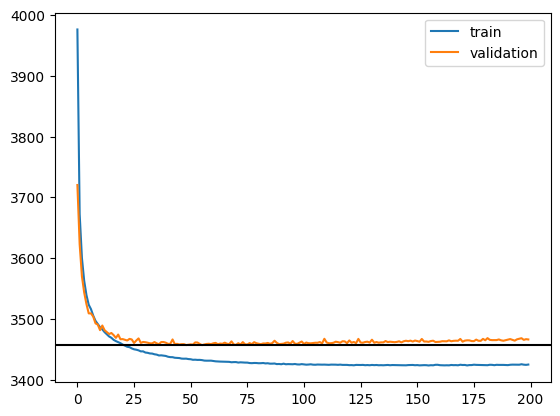

In [23]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [24]:
adata.write_h5ad('temp.h5ad')

In [25]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [26]:
adata.obsm['X_scVI'].shape

(58015, 60)

In [27]:
sc.pp.neighbors(adata, use_rep='X_scVI', )

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'print': Cannot determine Numba type of <class 'function'>

File "../../../../anaconda3/envs/scCRC/lib/python3.9/site-packages/pynndescent/pynndescent_.py", line 253:
def nn_descent_internal_low_memory_parallel(
    <source elided>
        if verbose:
            print("\t", n + 1, " / ", n_iters)
            ^

During: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x7331007af4c0>))
During: typing of call at /home/sapien/anaconda3/envs/scCRC/lib/python3.9/site-packages/pynndescent/pynndescent_.py (359)

During: resolving callee type: type(CPUDispatcher(<function nn_descent_internal_low_memory_parallel at 0x7331007af4c0>))
During: typing of call at /home/sapien/anaconda3/envs/scCRC/lib/python3.9/site-packages/pynndescent/pynndescent_.py (359)


File "../../../../anaconda3/envs/scCRC/lib/python3.9/site-packages/pynndescent/pynndescent_.py", line 359:
def nn_descent(
    <source elided>
    if low_memory:
        nn_descent_internal_low_memory_parallel(
        ^
